In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

np.set_printoptions(suppress=True)

In [2]:
yelpZip_preprocessed = pd.read_pickle('../../data/processed/yelpZip_preprocessed.pkl')

yelpZip_data = yelpZip_preprocessed.copy()
yelpZip_data.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,...,neg,neu,pos,compound,cap_word_count,digit_word_count,absolute_compound,length_deviation,review_count,extreme_rating_ratio
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0.000000,0.0000,1,...,0.513,0.487,0.000,-0.9287,0,0,0.9287,0.527778,1,0.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0.000000,0.0000,1,...,0.195,0.584,0.221,0.6128,0,2,0.6128,0.508065,1,0.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0.162733,0.3298,1,...,0.000,0.610,0.390,0.9153,1,0,0.9153,0.520000,4,0.0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0.000000,0.0000,1,...,0.016,0.614,0.370,0.9954,1,0,0.9954,0.446352,1,0.0
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0.000000,0.0000,1,...,0.000,0.518,0.482,0.9945,0,0,0.9945,0.480263,1,0.0


# Experiment 1  - without text features

## Prepare dataset to feed into model

In [3]:
yelpZip_data['label'].replace(1, True, inplace=True)
yelpZip_data['label'].replace(-1, False, inplace=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

In [5]:
# features = ['overall_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len']
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = x_train[features]
x_test = x_test[features]

## Train and Evaluate

### Experiment 1A. Without Oversampling

In [6]:
since = time.time()

classifier = LogisticRegression(max_iter=1000, n_jobs=-1)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.8673085770621097

Complete in 0.0m 46.4949734210968s


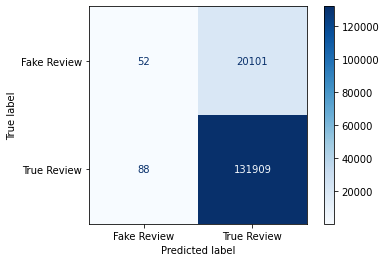

In [7]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [8]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.37      0.00      0.01     20153
        True       0.87      1.00      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.62      0.50      0.47    152150
weighted avg       0.80      0.87      0.81    152150



### Experiment 1B. With Oversampling

In [9]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 1.8140435218811035s


In [10]:
since = time.time()

classifier = LogisticRegression(max_iter=1000, n_jobs=-1)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.6802300361485376

Complete in 1.0m 2.075929880142212s


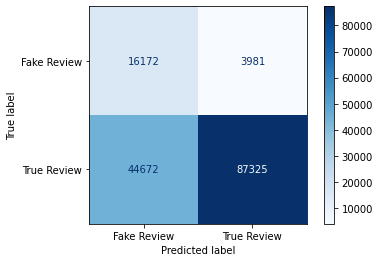

In [11]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [12]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.27      0.80      0.40     20153
        True       0.96      0.66      0.78    131997

    accuracy                           0.68    152150
   macro avg       0.61      0.73      0.59    152150
weighted avg       0.86      0.68      0.73    152150



# Experiment 2 - only text features

## Prepare dataset to feed into model

In [13]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [14]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 15.449288606643677s


In [15]:
since = time.time()

x_train = vectorizer.transform(x_train['corpus'])
x_test  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 20.996596097946167s


### 2. feature selection：chi-square

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=1000)
x_train_selected = pick_K.fit_transform(x_train, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 1000)
x_test_selected shape: (152150, 1000)


## Train and Evaluate

### Experiment 2A. Without Oversampling

In [17]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train_selected, y_train)
score = classifier.score(x_test_selected, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.8679066710483075

Complete in 0.0m 6.176638126373291s


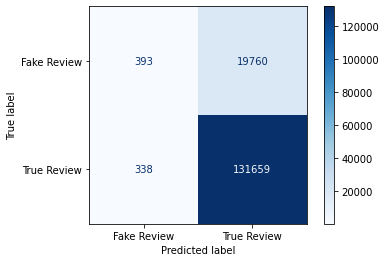

In [18]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [19]:
predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.54      0.02      0.04     20153
        True       0.87      1.00      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.70      0.51      0.48    152150
weighted avg       0.83      0.87      0.81    152150



### Experiment 2B. With Oversampling

In [20]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train_selected, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 1.0m 48.25989007949829s


In [21]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test_selected, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.7365494577719356

Complete in 0.0m 9.933497428894043s


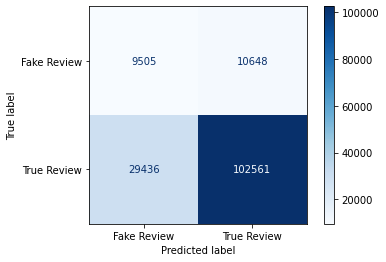

In [22]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [23]:
predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.24      0.47      0.32     20153
        True       0.91      0.78      0.84    131997

    accuracy                           0.74    152150
   macro avg       0.58      0.62      0.58    152150
weighted avg       0.82      0.74      0.77    152150



# Experiment 3 - both text features & behavior features

## Prepare dataset to feed into model

In [24]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [25]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 15.293104887008667s


In [26]:
since = time.time()

x_train_text = vectorizer.transform(x_train['corpus'])
x_test_text  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 20.95709729194641s


### 2. feature selection：chi-square

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=1000)
x_train_selected = pick_K.fit_transform(x_train_text, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test_text)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 1000)
x_test_selected shape: (152150, 1000)


### 3. Concat selected text features with other behavior features

In [28]:
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = sp.sparse.hstack((x_train_selected, x_train[features].values))
x_test = sp.sparse.hstack((x_test_selected, x_test[features].values))

In [29]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (456448, 1011)
x_test shape: (152150, 1011)


## Train and Evaluate

### Experiment 3A. Without Oversampling

In [30]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.8689845547157411

Complete in 0.0m 7.504557847976685s


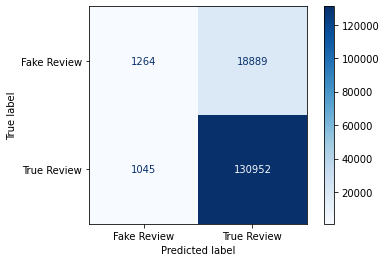

In [31]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [32]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.55      0.06      0.11     20153
        True       0.87      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.71      0.53      0.52    152150
weighted avg       0.83      0.87      0.82    152150



### Experiment 3B. With Oversampling

In [33]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 2.0m 47.42421770095825s


In [34]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.7343871179756819

Complete in 0.0m 13.201040744781494s


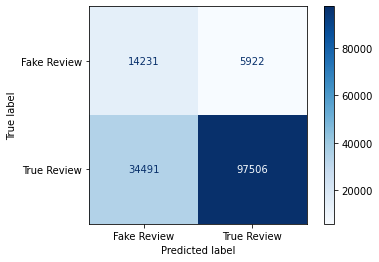

In [35]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [36]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.29      0.71      0.41     20153
        True       0.94      0.74      0.83    131997

    accuracy                           0.73    152150
   macro avg       0.62      0.72      0.62    152150
weighted avg       0.86      0.73      0.77    152150

